<a href="http://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project02%20-%20Text_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Document Clustering

Clustering is one of the most important Unsupervised Machine Learning Techniques. These algorithms come in handy, especially in situations where labeled data is a luxury. Clustering techniques help us understand the underlying patterns in data (more so around them being similar) along with the ability to bootstrap certain supervised learning approaches as well.

![](https://i.imgur.com/FaRYnUC.png)

Clustering techniques have been studied in depth over the years and there are some very powerful clustering algorithms available. For this tutorial, we will be working with a movie dataset containing movie plot, cast, genres and related other information. We will be working with __K-Means__ and __Ward-Hierarchical-Clustering__ methods.

In [8]:
!pip install textsearch
!pip install contractions
!pip install textsearch
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
import pandas as pd

df = pd.read_csv('https://github.com/dipanjanS/nlp_workshop_dhs18/raw/master/Unit%2010%20-%20Project%208%20-%20Movie%20Recommendations%20with%20Document%20Similarity/tmdb_5000_movies.csv.gz', compression='gzip')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null 

In [14]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [15]:
df = df[['title', 'tagline', 'overview', 'popularity']]
df.tagline.fillna('', inplace=True)
df['description'] = df['tagline'].map(str) + ' ' + df['overview']
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4800 entries, 0 to 4802
Data columns (total 5 columns):
title          4800 non-null object
tagline        4800 non-null object
overview       4800 non-null object
popularity     4800 non-null float64
description    4800 non-null object
dtypes: float64(1), object(4)
memory usage: 225.0+ KB


In [16]:
df.head()

,title,tagline,overview,popularity,description
0,Avatar,Enter the World of Pandora.,"In the 22nd century, a paraplegic Marine is di...",150.437577,Enter the World of Pandora. In the 22nd centur...
1,Pirates of the Caribbean: At World's End,"At the end of the world, the adventure begins.","Captain Barbossa, long believed to be dead, ha...",139.082615,"At the end of the world, the adventure begins...."
2,Spectre,A Plan No One Escapes,A cryptic message from Bond’s past sends him o...,107.376788,A Plan No One Escapes A cryptic message from B...
3,The Dark Knight Rises,The Legend Ends,Following the death of District Attorney Harve...,112.312950,The Legend Ends Following the death of Distric...
4,John Carter,"Lost in our world, found in another.","John Carter is a war-weary, former military ca...",43.926995,"Lost in our world, found in another. John Cart..."


## Your Turn: Cluster Similar Movies

Here you will learn how to cluster text documents (in this case movies). We will use the following pipeline:
- Text pre-processing
- Feature Engineering
- Clustering Using K-Means
- Finding Optimal Value for K
- Prepare Movie Clusters

Clustering is an unsupervised approach to find groups of similar items in any given dataset. There are different clustering algorithms and __K-Means__ is a pretty simple yet affect one. Most movies span different emotions and can be categorized into multiple genres (same is the case with movies listed in our current dataset). Can clustering of movie descriptions help us understand these groupings?

Similarity analysis (in the previous section) was a good starting point, but can we do better? 

## Text pre-processing

We will do some basic text pre-processing on our movie descriptions before we build our features

In [17]:
import nltk
import re
import numpy as np
import contractions

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    doc = contractions.fix(doc)
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    #filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(list(df['description']))
len(norm_corpus)

4800

## Extract TF-IDF Features

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

stop_words = stop_words + ['one', 'two', 'three', 'four', 'five', 'get']
cv = CountVectorizer(ngram_range=(1, 2), min_df=0.001, max_df=0.99, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix.shape

(4800, 6100)

## Cluster Movies using K-Means

In [33]:
from sklearn.cluster import KMeans

NUM_CLUSTERS = 6
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=100, random_state=42).fit(cv_matrix)
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
       n_clusters=6, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [34]:
from collections import Counter

Counter(km.labels_)

Counter({0: 126, 1: 547, 2: 123, 3: 2929, 4: 625, 5: 450})

In [0]:
df['kmeans_cluster'] = km.labels_

In [0]:
movie_clusters = (df[['title', 'kmeans_cluster', 'popularity']]
                  .sort_values(by=['kmeans_cluster', 'popularity'], 
                               ascending=False)
                  .groupby('kmeans_cluster').head(20))
movie_clusters = movie_clusters.copy(deep=True)

In [38]:
feature_names = cv.get_feature_names()
topn_features = 30
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

# get key features for each cluster
# get movies belonging to each cluster
for cluster_num in range(NUM_CLUSTERS):
    key_features = [feature_names[index] 
                        for index in ordered_centroids[cluster_num, :topn_features]]
    movies = movie_clusters[movie_clusters['kmeans_cluster'] == cluster_num]['title'].values.tolist()
    print('CLUSTER #'+str(cluster_num+1))
    print('Key Features:', key_features)
    print('Popular Movies:', movies)
    print('-'*80)

CLUSTER #1
Key Features: ['school', 'high', 'high school', 'friends', 'girl', 'new', 'students', 'year', 'become', 'life', 'young', 'best', 'man', 'decides', 'together', 'story', 'student', 'teacher', 'help', 'town', 'hes', 'world', 'college', 'years', 'go', 'friend', 'popular', 'schools', 'graduation', 'make']
Popular Movies: ['The Amazing Spider-Man', 'The Amazing Spider-Man 2', 'Spider-Man', 'Grease', 'Chronicle', 'Nerve', '21 Jump Street', 'A Beautiful Mind', '22 Jump Street', 'Project X', 'Easy A', 'Kick-Ass', 'Unfriended', 'Bridge to Terabithia', 'The DUFF', 'Grown Ups', 'American Wedding', 'The Best of Me', 'Superbad', 'Kiss Kiss Bang Bang']
--------------------------------------------------------------------------------
CLUSTER #2
Key Features: ['new', 'york', 'new york', 'city', 'world', 'family', 'young', 'york city', 'man', 'years', 'must', 'time', 'back', 'find', 'town', 'home', 'hes', 'finds', 'story', 'lives', 'life', 'together', 'film', 'friends', 'way', 'first', 'become

In [0]:
from gensim.models import FastText

tokenized_docs = [doc.split() for doc in norm_corpus]
ft_model = FastText(tokenized_docs, size=300, window=40, min_count=2, workers=4, sg=1, iter=100)

In [0]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [88]:
doc_vecs_ft = averaged_word2vec_vectorizer(tokenized_docs, ft_model, 300)
doc_vecs_ft.shape

(4800, 300)

In [0]:
NUM_CLUSTERS = 6
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=100, random_state=42).fit(doc_vecs_ft)

In [91]:
Counter(km.labels_)

Counter({0: 1270, 1: 740, 2: 433, 3: 873, 4: 911, 5: 573})

In [0]:
df['kmeans_cluster'] = km.labels_
movie_clusters = (df[['title', 'kmeans_cluster', 'popularity']]
                  .sort_values(by=['kmeans_cluster', 'popularity'], 
                               ascending=False)
                  .groupby('kmeans_cluster').head(30))
movie_clusters = movie_clusters.copy(deep=True)

In [93]:
for cluster_num in range(NUM_CLUSTERS):
    movies = movie_clusters[movie_clusters['kmeans_cluster'] == cluster_num]['title'].values.tolist()
    print('CLUSTER #'+str(cluster_num+1))
    print('Popular Movies:', movies)
    print('-'*80)

CLUSTER #1
Popular Movies: ['Frozen', "Pirates of the Caribbean: Dead Man's Chest", "Pirates of the Caribbean: At World's End", 'Forrest Gump', 'Pirates of the Caribbean: On Stranger Tides', 'Inside Out', 'Twilight', 'Spirited Away', 'Chappie', 'Night at the Museum: Secret of the Tomb', 'The Twilight Saga: Eclipse', 'Monsters, Inc.', 'Cinderella', 'It Follows', 'The Revenant', 'Harry Potter and the Half-Blood Prince', 'Up', "Pan's Labyrinth", 'The Lion King', 'The Amazing Spider-Man 2', 'Prisoners', 'American Sniper', 'The Devil Wears Prada', 'The Age of Adaline', 'Taken', 'American Beauty', 'The Pursuit of Happyness', 'The Equalizer', 'The Shining', 'About Time']
--------------------------------------------------------------------------------
CLUSTER #2
Popular Movies: ['Interstellar', 'Deadpool', 'Guardians of the Galaxy', 'Mad Max: Fury Road', 'Dawn of the Planet of the Apes', 'Big Hero 6', 'The Martian', 'Avatar', 'The Avengers', 'Teenage Mutant Ninja Turtles', 'X-Men: Apocalypse',

## Hierarchical Clustering
So far, we were successfull in clustering movies using __K-Means__. But is there any further level of understanding we can extract from this dataset in an unsupervised manner?

Hierarchical Clustering to the rescue. K-Means helped us understand similarities amongst movies, with hierarchical clustering we can aim at understanding abstract or higher level concepts which are common across groups of movies. There are primarily two ways in which hierarchical clustering can be performed:

- Divisive : The algorithm begins with every element in one big generic cluster and then goes on dividing them into specific clusters in a recursive manner.
- Agglomerative : In this case, the algorithm starts by placing every element into a cluster of its own and then goes on merging them into more general clusters in a recursive manner (till they all merge into one big cluster).

For this tutorial, we will work with __Ward clustering algorithm__. Ward clustering is an agglomerative clustering method, i.e. at each stage, the pair of clusters with minimum _between-cluster distance_ (or wcss) are merged. 

To work with Ward Clustering Algorithm, we perform the following steps:
-  Prepare a cosine distance matrix
-  Calclate a linkage_matrix
-  Plot the hierarchical structure as a dendrogram.  

In [0]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

### Calculate Linkage Matrix using Cosine Similarity

In [0]:
def ward_hierarchical_clustering(feature_matrix):
    
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix

### Plot Hierarchical Structure as a Dendrogram

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_hierarchical_clusters(linkage_matrix, movie_data, p=100, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    movie_titles = movie_data['title'].values.tolist()
    # plot dendrogram
    R = dendrogram(linkage_matrix, orientation="left", labels=movie_titles,
                    truncate_mode='lastp', 
                    p=p,  
                    no_plot=True)
    temp = {R["leaves"][ii]: movie_titles[ii] for ii in range(len(R["leaves"]))}
    def llf(xx):
        return "{}".format(temp[xx])
    ax = dendrogram(
            linkage_matrix,
            truncate_mode='lastp',
            orientation="left",
            p=p,  
            leaf_label_func=llf, 
            leaf_font_size=10.,
            )
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.savefig('movie_hierachical_clusters.png', dpi=200)

In [0]:
linkage_matrix = ward_hierarchical_clustering(doc_vecs_ft)

In [108]:
np.set_printoptions(suppress=True)
print(linkage_matrix)

[[ 667.         2991.            1.32933468    2.        ]
 [1452.         4165.            1.4146267     2.        ]
 [ 137.          181.            1.53815994    2.        ]
 ...
 [4399.         9591.           43.49681978  357.        ]
 [9595.         9596.           55.31828313 2950.        ]
 [9594.         9597.           88.83099247 4800.        ]]


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


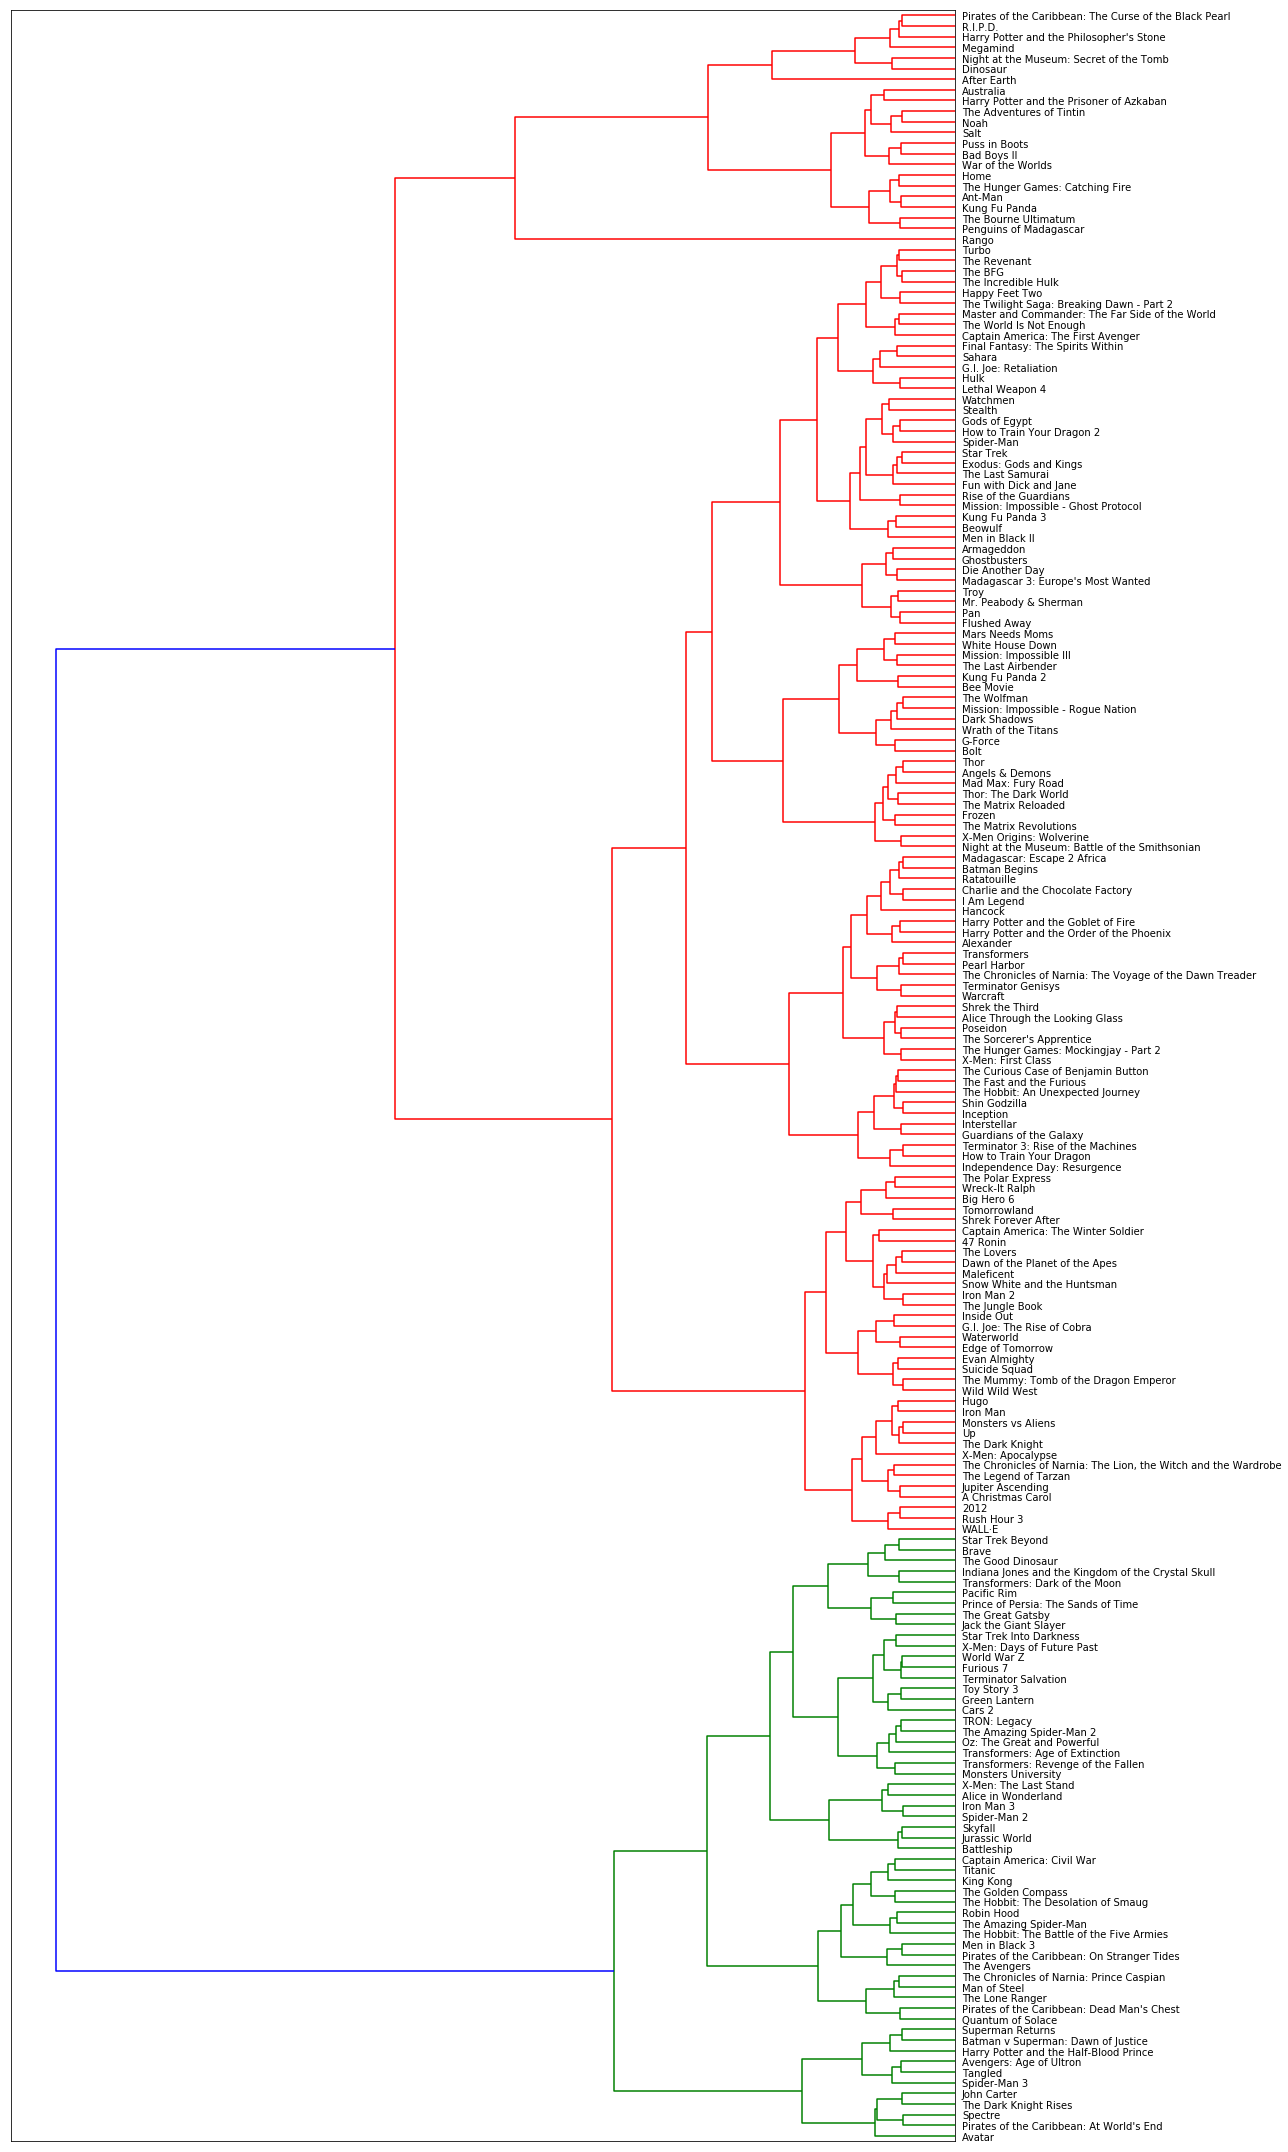

In [111]:
plot_hierarchical_clusters(linkage_matrix,
                           p=200,
                           movie_data=df,
                           figure_size=(18, 30))